In [ ]:
from pathlib import Path
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
HERE = Path.cwd() 
PKL_DIR = (HERE / ".." / "experiments_results" / "Convergance" / "pkls_all_datasets").resolve()

pkl_files = sorted(PKL_DIR.glob("*.pkl"))
if len(pkl_files) == 0:
    raise FileNotFoundError(f"No hay .pkl en: {PKL_DIR}")

def load_pkl(path: Path):
    with open(path, "rb") as f:
        return pickle.load(f)

def to_top1_percent(x):
    arr = np.asarray(x, dtype=float)
    if np.nanmax(arr) <= 1.0:
        arr = arr * 100.0
    return arr

def extract_val_top1(obj):
    """
    Espera un dict con 'val_top1'. Si no está, intenta fallback.
    """
    if isinstance(obj, dict):
        if "val_top1" in obj:
            return to_top1_percent(obj["val_top1"])
        # fallback común si usaste otros nombres
        for k in ["val_acc1", "val_top1_acc", "valid_top1", "val_accuracy_top1"]:
            if k in obj:
                return to_top1_percent(obj[k])

    raise KeyError("No encuentro 'val_top1' (ni fallbacks) en el objeto del pkl.")

def parse_model_dataset(fname: str):
    """
    Ejemplos:
      OutGrid_OxfordPets_14m.pkl  -> model=OutGrid_14m, dataset=OxfordPets
      OutGrid_TinyImagnet200.pkl  -> model=OutGrid, dataset=TinyImagnet200
      ResNet50_Food101.pkl        -> model=ResNet50, dataset=Food101
      Swin_SVHN.pkl               -> model=Swin, dataset=SVHN
      MaxViT_OxfordPets.pkl       -> model=MaxViT, dataset=OxfordPets
      Swin_OxfordPets37.pkl       -> model=Swin, dataset=OxfordPets37
    """
    stem = Path(fname).stem
    parts = stem.split("_")

    # Modelo base
    model = parts[0]

    # Caso OutGrid_..._14m
    if model.lower() == "outgrid" and parts[-1].lower() == "14m":
        model = "OutGrid_14m"
        dataset = "_".join(parts[1:-1])
    else:
        dataset = "_".join(parts[1:])

    return model, dataset

def pretty_dataset_name(ds: str):
    # etiquetas "paper-like"
    mapping = {
        "Food101": "Food-101",
        "SVHN": "SVHN",
        "OxfordPets": "Oxford-IIIT Pets",
        "OxfordPets37": "Oxford-IIIT Pets (37)",
        "TinyImagnet200": "Tiny-ImageNet-200",
        "TinyImagenet200": "Tiny-ImageNet-200",
        "TinyImageNet200": "Tiny-ImageNet-200",
        "TinyImagnet": "Tiny-ImageNet",}
    
    return mapping.get(ds, ds)

def pretty_model_name(m: str):
    mapping = {
        "Swin": "Swin",
        "ResNet50": "ResNet-50",
        "MaxViT": "MaxViT",
        "OutGrid": "OutGrid",
        "OutGrid_14m": "OutGrid (14M)",}
    
    return mapping.get(m, m)


In [ ]:

import numpy as np

def extract_series(obj, key: str):
    if not isinstance(obj, dict):
        raise TypeError("El pkl no es un diccionario.")
    if key not in obj:
        raise KeyError(f"El pkl no tiene la key '{key}'. Keys disponibles: {list(obj.keys())[:20]}")
    return np.asarray(obj[key], dtype=float)

data = {}

for fp in pkl_files:
    model, dataset = parse_model_dataset(fp.name)
    obj = load_pkl(fp)
    curve = extract_val_top1(obj)

    data.setdefault(dataset, {})
    data[dataset][model] = curve

datasets_order = []
for candidate in ["Food101", "OxfordPets37", "OxfordPets", "TinyImagnet200", "SVHN"]:
    if candidate in data and candidate not in datasets_order:
        datasets_order.append(candidate)

wanted_priority = ["Food101", "OxfordPets37", "OxfordPets", "TinyImagnet200", "SVHN"]
datasets = []
for w in wanted_priority:
    if w in data and w not in datasets:
        datasets.append(w)
    if len(datasets) == 4:
        break

if len(datasets) < 4:
    datasets = list(data.keys())[:4]

models_order = ["Swin", "ResNet50", "MaxViT", "OutGrid", "OutGrid_14m"]


data_loss = {}

for fp in pkl_files:
    model, dataset = parse_model_dataset(fp.name)  
    obj = load_pkl(fp)

    curve = np.asarray(obj["val_loss"], dtype=float)

    data_loss.setdefault(dataset, {})
    data_loss[dataset][model] = curve


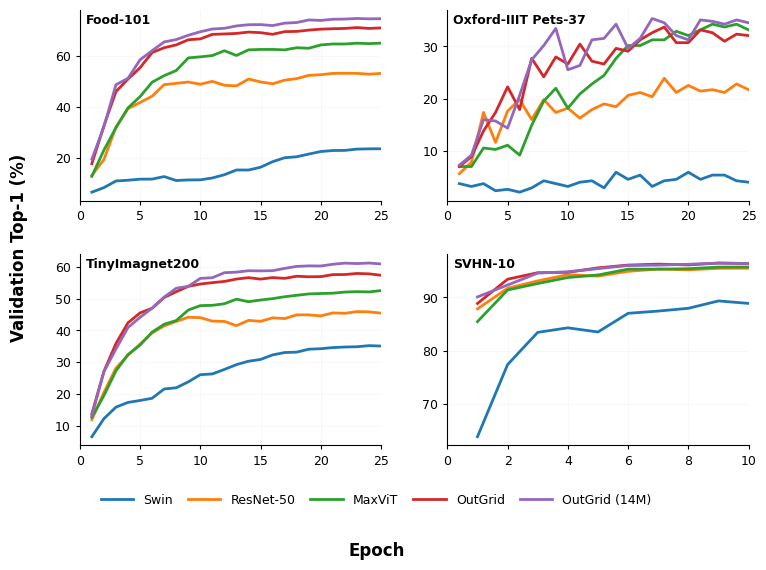

Saved: C:\Users\alejo\OneDrive\Escritorio\Profesional\Modelaje\Modelos de DL\outlook-grid-vision-transformer\graphs\convergence_2x2_paper.pdf
Saved: C:\Users\alejo\OneDrive\Escritorio\Profesional\Modelaje\Modelos de DL\outlook-grid-vision-transformer\graphs\convergence_2x2_paper.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def pretty_dataset_name(ds: str):
    mapping = {
        "Food101": "Food-101",
        "OxfordPets37": "Oxford-IIIT Pets-37",
        "OxfordPets": "Oxford-IIIT Pets-37",   # si tú ya decidiste usar 37, lo forzamos así
        "TinyImagenet200": "Tiny-ImageNet-200",
        "SVHN": "SVHN-10",}
    
    return mapping.get(ds, ds)

def pretty_model_name(m: str):
    return {
        "Swin": "Swin",
        "ResNet50": "ResNet-50",
        "MaxViT": "MaxViT",
        "OutGrid": "OutGrid",
        "OutGrid_14m": "OutGrid (14M)",}.get(m, m)

EPOCH_CAP = {
    "Food101": 25,
    "OxfordPets37": 25,
    "OxfordPets": 25,
    "TinyImagenet200": 25,
    "SVHN": 10}

def common_max_epoch(curves_dict, models_order):
    lens = [len(curves_dict[m]) for m in models_order if m in curves_dict]
    return min(lens) if lens else None

plt.rcParams.update({
    "font.size": 9,
    "axes.linewidth": 0.8,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,})


fig, axes = plt.subplots(2, 2, figsize=(7.6, 6.6), constrained_layout=False)
axes = axes.flatten()

legend_handle_by_model = {}

for ax, ds in zip(axes, datasets):
    if ds not in data:
        ax.axis("off")
        continue

    curves = data[ds]
    max_e_common = common_max_epoch(curves, models_order)
    max_e = min(max_e_common, EPOCH_CAP.get(ds, max_e_common))

    for m in models_order:
        if m not in curves:
            continue

        y_raw = np.asarray(curves[m], dtype=float)[:max_e]
        x = np.arange(0, len(y_raw) + 1)     #
        y = np.r_[np.nan, y_raw]            

        (line,) = ax.plot(x, y, linewidth=2.0)
        if m not in legend_handle_by_model:
            legend_handle_by_model[m] = line


    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, which="major", linewidth=0.5, alpha=0.12)
    ax.tick_params(direction="out", length=3, width=0.8)
    ax.set_xlim(0, max_e)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))

    ax.text(
        0.02, 0.98, pretty_dataset_name(ds),
        transform=ax.transAxes,
        ha="left", va="top",
        fontweight="bold")

fig.subplots_adjust(left=0.11, right=0.99, top=0.90, bottom=0.24, wspace=0.22, hspace=0.28)
fig.text(0.5, 0.08, "Epoch", ha="center", va="center", fontweight="bold", fontsize=12)
fig.text(0.03, 0.54, "Validation Top-1 (%)", ha="center", va="center",
         rotation="vertical", fontweight="bold", fontsize=12)

handles = [legend_handle_by_model[m] for m in models_order if m in legend_handle_by_model]
labels  = [pretty_model_name(m) for m in models_order if m in legend_handle_by_model]

fig.legend(
    handles, labels,
    loc="lower center",
    ncol=5,
    frameon=False,
    bbox_to_anchor=(0.5, 0.13),  
    handlelength=2.6,
    columnspacing=1.2)


OUT_PDF = (HERE / "convergence_2x2_paper.pdf").resolve()
OUT_PNG = (HERE / "convergence_2x2_paper.png").resolve()
fig.savefig(OUT_PDF, bbox_inches="tight")
fig.savefig(OUT_PNG, dpi=600, bbox_inches="tight")

plt.show()
print("Saved:", OUT_PDF)
print("Saved:", OUT_PNG)


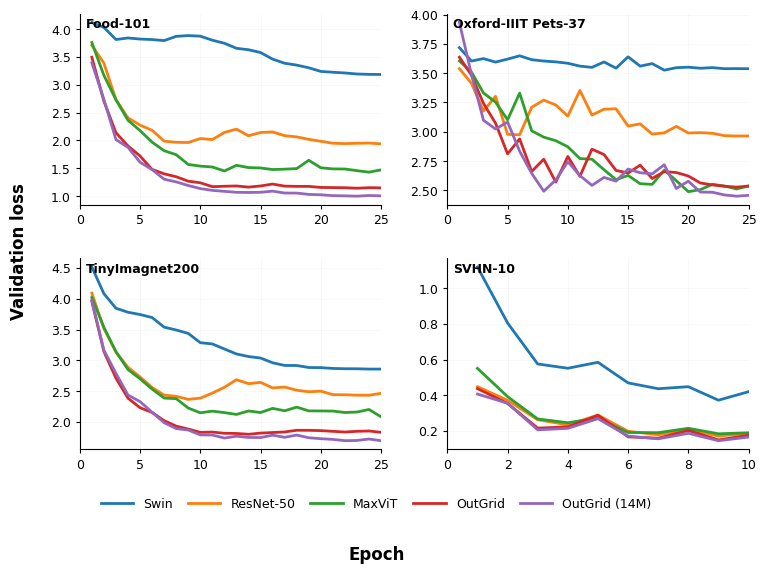

Saved: C:\Users\alejo\OneDrive\Escritorio\Profesional\Modelaje\Modelos de DL\outlook-grid-vision-transformer\graphs\convergence_2x2_val_loss.pdf
Saved: C:\Users\alejo\OneDrive\Escritorio\Profesional\Modelaje\Modelos de DL\outlook-grid-vision-transformer\graphs\convergence_2x2_val_loss.png


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


EPOCH_CAP = {
    "Food101": 25,
    "OxfordPets37": 25,
    "OxfordPets": 25,
    "TinyImagenet200": 25,
    "SVHN": 10}

def common_max_epoch(curves_dict, models_order):
    lens = [len(curves_dict[m]) for m in models_order if m in curves_dict]
    return min(lens) if lens else None

plt.rcParams.update({
    "font.size": 9,
    "axes.linewidth": 0.8,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,})

fig, axes = plt.subplots(2, 2, figsize=(7.6, 6.6), constrained_layout=False)
axes = axes.flatten()

legend_handle_by_model = {}

for ax, ds in zip(axes, datasets):
    if ds not in data_loss:
        ax.axis("off")
        continue

    curves = data_loss[ds]

    max_e_common = common_max_epoch(curves, models_order)
    max_e = min(max_e_common, EPOCH_CAP.get(ds, max_e_common))

    for m in models_order:
        if m not in curves:
            continue

        y_raw = np.asarray(curves[m], dtype=float)[:max_e]
        x = np.arange(0, len(y_raw) + 1)   # 0..max_e
        y = np.r_[np.nan, y_raw]           # NaN at epoch 0 (just to show the tick)

        (line,) = ax.plot(x, y, linewidth=2.0)

        if m not in legend_handle_by_model:
            legend_handle_by_model[m] = line

    # clean aesthetics
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, which="major", linewidth=0.5, alpha=0.12)
    ax.tick_params(direction="out", length=3, width=0.8)

    ax.set_xlim(0, max_e)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))

    ax.text(
        0.02, 0.98, pretty_dataset_name(ds),
        transform=ax.transAxes,
        ha="left", va="top",
        fontweight="bold")

fig.subplots_adjust(left=0.11, right=0.99, top=0.90, bottom=0.24, wspace=0.22, hspace=0.28)

fig.text(0.5, 0.08, "Epoch", ha="center", va="center", fontweight="bold", fontsize=12)
fig.text(0.03, 0.54, "Validation loss", ha="center", va="center",
         rotation="vertical", fontweight="bold", fontsize=12)

handles = [legend_handle_by_model[m] for m in models_order if m in legend_handle_by_model]
labels  = [pretty_model_name(m) for m in models_order if m in legend_handle_by_model]

fig.legend(
    handles, labels,
    loc="lower center",
    ncol=5,
    frameon=False,
    bbox_to_anchor=(0.5, 0.13),
    handlelength=2.6,
    columnspacing=1.2)

OUT_PDF = (HERE / "convergence_2x2_val_loss.pdf").resolve()
OUT_PNG = (HERE / "convergence_2x2_val_loss.png").resolve()
fig.savefig(OUT_PDF, bbox_inches="tight")
fig.savefig(OUT_PNG, dpi=600, bbox_inches="tight")

plt.show()
print("Saved:", OUT_PDF)
print("Saved:", OUT_PNG)
